# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Análise Estatística Para Data Science com Linguagem Python</font>

## <font color='blue'>Lab 4 - Parte 3</font>
## <font color='blue'>Modelagem Estatística de Séries Temporais</font>

![title](imagens/Lab4.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.18


In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [2]:
# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.pyplot import figure

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Filtrando warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

statsmodels: 0.14.1
numpy      : 1.26.4
matplotlib : 3.8.2
sklearn    : 1.3.2
pandas     : 2.0.3



## Carregando e Organizando os Dados

In [4]:
# Carrega os dados
dados_treino = pd.read_csv("dados/dataset_treino.csv")
dados_teste = pd.read_csv("dados/dataset_teste.csv")

Vamos fazer algumas transformações nos dados para criar o modelo.

In [5]:
# Converte a coluna data para o tipo correto
dados_treino['data'] = pd.to_datetime(dados_treino.data, format = '%d-%m-%Y %H:%M')

In [6]:
# Converte a coluna data para o tipo correto
dados_teste['data'] = pd.to_datetime(dados_teste.data, format = '%d-%m-%Y %H:%M')

In [7]:
# Definimos o índice do dataset
dados_treino.index = dados_treino['data']

In [8]:
# Removemos a coluna ID, pois ela não é relevante neste caso
dados_treino.drop('id', axis = 1, inplace = True)

In [9]:
# Removemos a coluna data, pois ela não é relevante neste caso
dados_treino.drop('data', axis = 1, inplace = True)

In [10]:
# Variável target 
target = dados_treino['veiculos_produzidos']

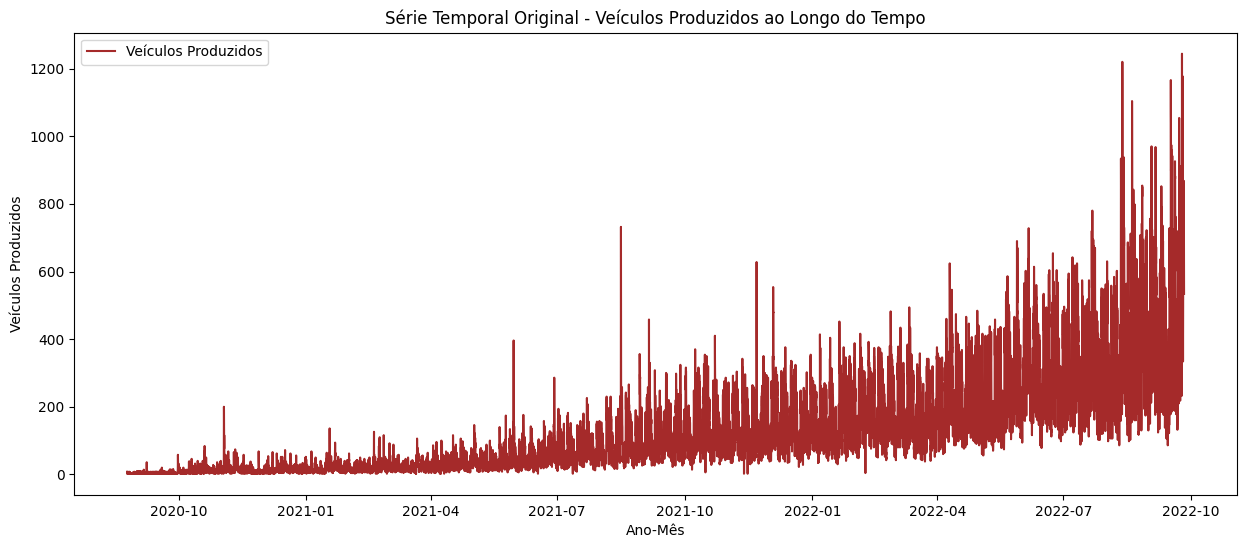

In [11]:
# Plot
figure(figsize = (15, 6))
plt.title("Série Temporal Original - Veículos Produzidos ao Longo do Tempo")
plt.plot(target, label = "Veículos Produzidos", color = 'brown')
plt.xlabel("Ano-Mês")
plt.ylabel("Veículos Produzidos")
plt.legend(loc = "best")

Já sabemos que a série é estacionária. Vamos direto para a modelagem.

## Pré-Processamento

Vamos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [12]:
# Os dados de treino serão divididos em dados de treino e validação.
# Observe que os registros são separados em ordem cronológica.
df_treino = dados_treino.iloc[0:16057]
df_valid = dados_treino.iloc[16058:]

In [13]:
df_treino.shape

(16057, 1)

In [14]:
df_valid.shape

(2230, 1)

In [15]:
array_dados_treino = np.asanyarray(df_treino['veiculos_produzidos'])

In [16]:
type(array_dados_treino)

numpy.ndarray

In [17]:
# Aplicando transformação de log (colocando os dados na mesma escala, o que é requerido pelos modelos ARIMA)
df_treino_log = np.log(df_treino['veiculos_produzidos'])

## Forecasting - Modelagem Preditiva Para Séries Temporais

Em Estatística e Econometria, e em particular na análise de séries temporais, um modelo de média móvel integrada auto-regressiva (ARIMA) é uma generalização de um modelo de média móvel auto-regressiva (ARMA). 

Ambos os modelos são ajustados a dados de séries temporais para melhor entender os dados ou para prever pontos futuros na série (previsão). Os modelos ARIMA são aplicados em alguns casos em que os dados mostram evidências de não estacionariedade, onde uma etapa inicial de diferenciação (correspondente à parte "integrada" do modelo) pode ser aplicada uma ou mais vezes para eliminar a não estacionariedade. 

A parte AR do ARIMA indica que a variável de interesse em evolução é regredida com seus próprios valores defasados (isto é, anteriores). A parte MA indica que o erro de regressão é na verdade uma combinação linear de termos de erro cujos valores ocorreram contemporaneamente e em vários momentos no passado. O I (para "integrado") indica que os valores dos dados foram substituídos pela diferença entre seus valores e os valores anteriores (e esse processo de diferenciação pode ter sido executado mais de uma vez). O objetivo de cada um desses recursos é fazer com que o modelo ajuste os dados da melhor maneira possível.

Modelos ARIMA não sazonais são geralmente designados ARIMA(p, d, q), em que os parâmetros p, d e q são números inteiros não negativos, p é a ordem (número de intervalos de tempo) do modelo autoregressivo, d é o grau de diferenciação (o número de vezes que os dados tiveram valores passados subtraídos) e q é a ordem do modelo de média móvel. 

Modelos ARIMA sazonais são geralmente designados ARIMA (p, d, q) (P, D, Q) m, em que m refere-se ao número de períodos em cada season e os maiúsculos P, D, Q referem-se ao autorregressivo, diferenciado, e termos da média móvel da parte sazonal do modelo ARIMA.

Quando dois dos três termos são zeros, o modelo pode ser referido com base no parâmetro diferente de zero, eliminando "AR", "I" ou "MA" da sigla que descreve o modelo. Por exemplo, ARIMA (1,0,0) é AR (1), ARIMA (0,1,0) é I (1) e ARIMA (0,0,1) é MA (1).

### Implementando a Estratégia 4 de Forecasting - Modelo ARIMA

Para a versão 3 criamos um Modelo ARIMA.

ARIMA é uma sigla que significa AutoRegressive Integrated Moving Average. É um modelo estatístico amplamente utilizado na modelagem de séries temporais para prever valores futuros baseados em observações passadas. O modelo ARIMA combina elementos de modelos autorregressivos (AR), diferenciação (I) e médias móveis (MA) para lidar com tendências, sazonalidades e irregularidades na série temporal. O modelo é especificado por três parâmetros inteiros (p, d, q), que representam o número de termos autorregressivos, o número de diferenciações necessárias para tornar a série estacionária e o número de termos de média móvel, respectivamente. O ARIMA é frequentemente usado com sucesso em muitos tipos de séries temporais e é considerado um dos modelos mais versáteis e robustos para previsão de séries temporais.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [18]:
# Cria o Modelo ARIMA

# Definimos:

# p = 2
# d = 1
# q = 0

# Modelo
modelo_AR = ARIMA(df_treino_log, order = (2, 1, 0), freq = 'H')

In [19]:
# Treinamento
modelo_v3 = modelo_AR.fit()

In [20]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino_log
previsoes_v3 = modelo_v3.fittedvalues

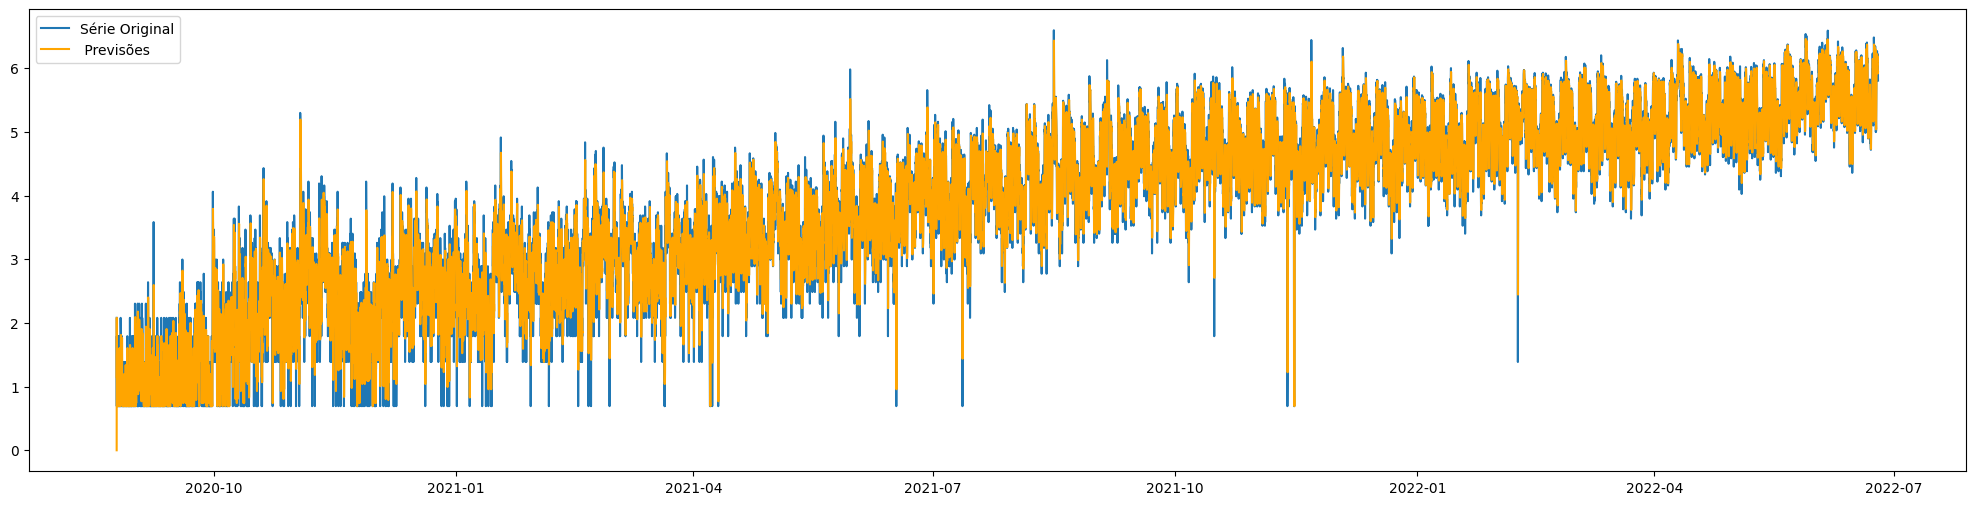

In [21]:
# Plot
figure(figsize = (25, 6))
plt.plot(dados_reais, label = 'Série Original')
plt.plot(previsoes_v3, color = 'orange', label = ' Previsões')
plt.legend(loc = 'best')
plt.show()

In [22]:
# Sumário do Modelo 
modelo_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     veiculos_produzidos   No. Observations:                16057
Model:                  ARIMA(2, 1, 0)   Log Likelihood               -8119.356
Date:                 Fri, 22 Mar 2024   AIC                          16244.711
Time:                         20:11:59   BIC                          16267.763
Sample:                     08-25-2020   HQIC                         16252.334
                          - 06-25-2022                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3419      0.005    -68.096      0.000      -0.352      -0.332
ar.L2         -0.0695      0.006    -11.737      0.000      -0.081      -0.058
sigma2         0.1610      0.001    158.760      0.000       0.159       0.163
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12378.93
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Vamos fazer previsões com o modelo.

Agora vamos fazer previsões com o modelo treinado usando dados de validação.

In [23]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
df_valid_log = np.log(df_valid['veiculos_produzidos'])

In [24]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v3 = modelo_v3.forecast(len(df_valid_log), alpha = 0.05)

In [25]:
df_previsoes_v3.shape

(2230,)

In [26]:
df_previsoes_v3.head()

2022-06-25 01:00:00    5.853056
2022-06-25 02:00:00    5.847868
2022-06-25 03:00:00    5.846309
2022-06-25 04:00:00    5.847203
2022-06-25 05:00:00    5.847006
Freq: H, Name: predicted_mean, dtype: float64

In [27]:
# Criamos a série para o gráfico
fc_series = pd.Series(df_previsoes_v3, index = df_valid_log.index)

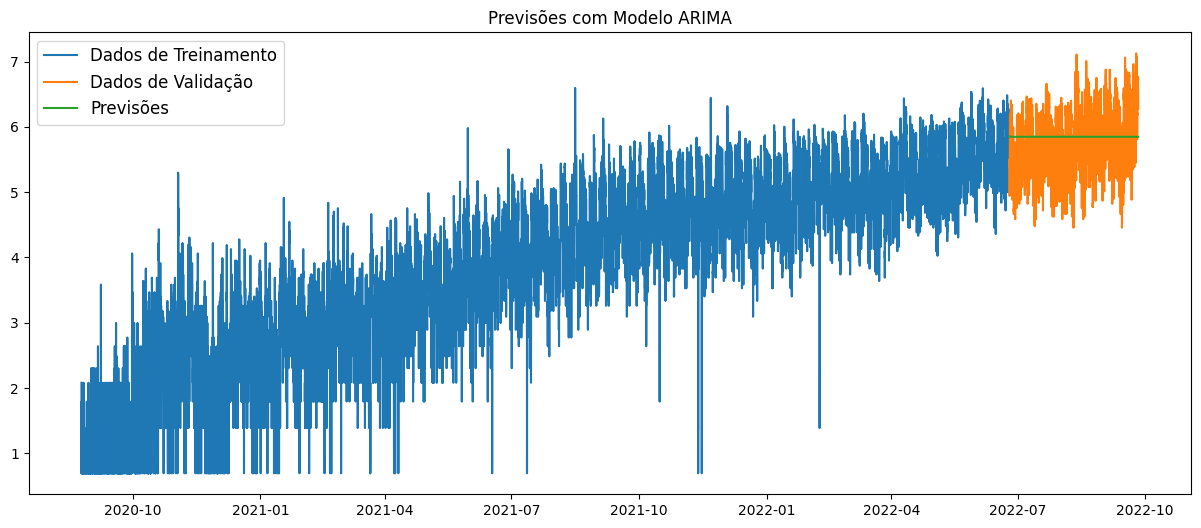

In [28]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino_log, label = 'Dados de Treinamento')
plt.plot(df_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

Pronto! Temos a previsão da nossa série com o modelo criado. Vamos calcular o erro do modelo.

In [29]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [30]:
# Define valor real e valor previsto
y_true = df_valid_log
y_pred = fc_series

In [31]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rsme = sqrt(mean_squared_error(y_true, y_pred))
print(metrica_rsme)

0.5136328974922741


Opa! Reduzimos de forma considerável o erro do nosso modelo. Não é por acaso que Modelos ARIMA fazem tanto sucesso. 

Você pode estar estranhando o gráfico, mas o que fizemos foi usar a série com a transformação de log, o que muda a escala dos dados. Porém os dados são os mesmos. Daqui a pouco veremos como fazer a inversa da transformação de log.

### Implementando a Estratégia 5 de Forecasting - Modelo SARIMAX

SARIMAX é uma sigla que significa Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors. É uma extensão do modelo ARIMA que permite a inclusão de variáveis exógenas (regressores) para melhorar a previsão. Além dos três parâmetros inteiros (p, d, q) que especificam o comportamento autorregressivo, integrado e de média móvel da série temporal, o SARIMAX também inclui parâmetros adicionais que especificam a sazonalidade da série e a influência das variáveis exógenas. 

O SARIMAX é frequentemente usado em aplicações em que a série temporal é fortemente influenciada por fatores sazonais ou por outras variáveis que podem ser incluídas como regressores. Ele é amplamente utilizado para previsão em muitos setores, como finanças, economia, varejo e produção.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [32]:
# Cria o modelo
modelo_SARIMAX = SARIMAX(df_treino_log, trend = 'n', order = (6,1,0), seasonal_order = (0,1,1,12))

In [33]:
# Treinamento do modelo
modelo_v4 = modelo_SARIMAX.fit(disp = True)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11522D-01    |proj g|=  8.36031D-01

At iterate    1    f=  5.24014D-01    |proj g|=  2.60584D-01

At iterate    2    f=  5.20111D-01    |proj g|=  7.32641D-02

At iterate    3    f=  5.18655D-01    |proj g|=  7.31877D-02

At iterate    4    f=  5.10825D-01    |proj g|=  2.06997D-01

At iterate    5    f=  5.07025D-01    |proj g|=  1.18639D-01

At iterate    6    f=  4.99814D-01    |proj g|=  9.16718D-02

At iterate    7    f=  4.94614D-01    |proj g|=  1.75205D-01

At iterate    8    f=  4.84403D-01    |proj g|=  2.11909D-01

At iterate    9    f=  4.71473D-01    |proj g|=  5.02565D-02

At iterate   10    f=  4.68591D-01    |proj g|=  7.76723D-02

At iterate   11    f=  4.64945D-01    |proj g|=  4.54315D-02

At iterate   12    f=  4.62470D-01    |proj g|=  1.13879D-02

At iterate   13    f=  4.6

In [34]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino_log
previsoes_v4 = modelo_v4.fittedvalues

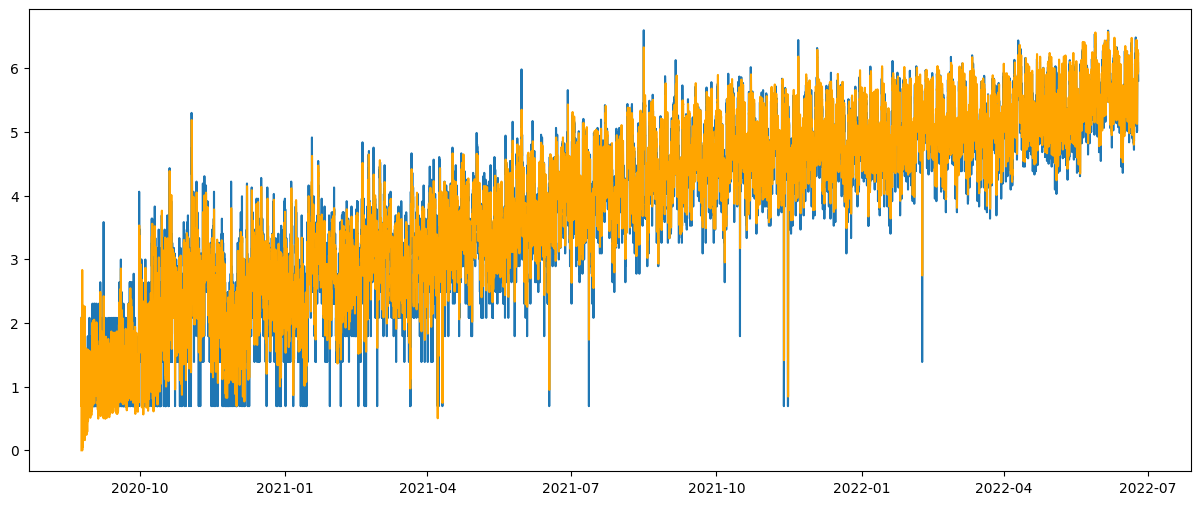

In [35]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original')
plt.plot(previsoes_v4, color = 'orange', label = 'Previsões')


In [37]:
# Sumário do Modelo 
modelo_v4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                  veiculos_produzidos   No. Observations:                16057
Model:             SARIMAX(6, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -7380.094
Date:                              Fri, 22 Mar 2024   AIC                          14776.188
Time:                                      20:23:41   BIC                          14837.652
Sample:                                  08-25-2020   HQIC                         14796.514
                                       - 06-25-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4178      0.005    -85.102      0.000      -0.427      -0.408
ar.L2         -0.1444      0.006    -22.494      0.000      -0.157      -0.132
ar.L3         -0.0446      0.007     -6.651      0.000      -0.058      -0.031
ar.L4         -0.0097      0.006     -1.584      0.113      -0.022       0.002
ar.L5          0.0146      0.006      2.400      0.016       0.003       0.027
ar.L6         -0.0011      0.006     -0.177      0.859      -0.013       0.011
ma.S.L12      -0.9965      0.001   -985.504      0.000      -0.998      -0.995
sigma2         0.1464      0.001    158.158      0.000       0.145       0.148
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15818.06
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v4 = modelo_v4.forecast(len(df_valid_log), alpha = 0.05)

In [39]:
df_previsoes_v4.shape

(2230,)

In [40]:
# Cria a série para o gráfico
fc_series = pd.Series(df_previsoes_v4, index = df_valid_log.index)

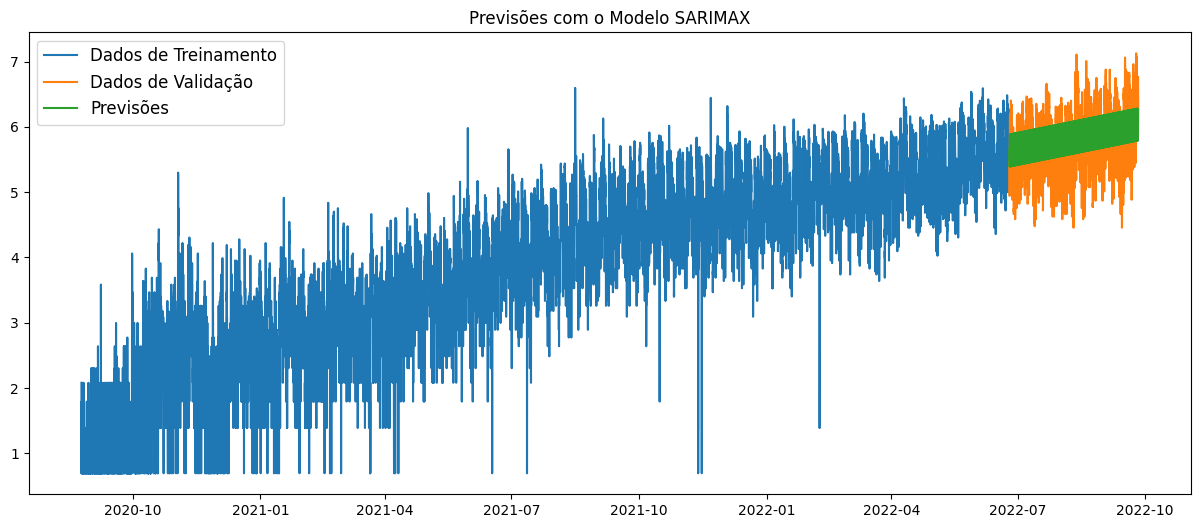

In [41]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino_log, label = 'Dados de Treinamento')
plt.plot(df_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com o Modelo SARIMAX')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [42]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf,-np.inf, np.nan), 0).reset_index(drop=True)

In [43]:
# Define valor real e valor previsto
y_true = df_valid_log
y_pred = fc_series

In [44]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rsme = sqrt(mean_squared_error(y_true, y_pred))
print(metrica_rsme)

0.4634346612036791


Chegamos à melhor versão do nosso modelo. Vamos usá-lo para fazer as previsões com dados de teste.

## Previsões com Novos Dados

In [45]:
dados_teste.head()

,id,data
0,18288,2022-09-26 00:00:00
1,18289,2022-09-26 01:00:00
2,18290,2022-09-26 02:00:00
3,18291,2022-09-26 03:00:00
4,18292,2022-09-26 04:00:00


In [46]:
# Vamos fazer a previsão para uma janela de 30 horas
previsoes = modelo_v4.predict(start = dados_teste.data[0], end = dados_teste.data[30], dynamic = False)

In [47]:
type(previsoes)

pandas.core.series.Series

In [48]:
previsoes[1:30]

2022-09-26 01:00:00    6.106434
2022-09-26 02:00:00    6.053912
2022-09-26 03:00:00    5.958851
2022-09-26 04:00:00    5.854575
2022-09-26 05:00:00    5.790920
2022-09-26 06:00:00    5.837234
2022-09-26 07:00:00    5.936057
2022-09-26 08:00:00    6.011433
2022-09-26 09:00:00    6.109165
2022-09-26 10:00:00    6.256591
2022-09-26 11:00:00    6.284654
2022-09-26 12:00:00    6.256249
2022-09-26 13:00:00    6.108586
2022-09-26 14:00:00    6.056063
2022-09-26 15:00:00    5.961003
2022-09-26 16:00:00    5.856727
2022-09-26 17:00:00    5.793071
2022-09-26 18:00:00    5.839386
2022-09-26 19:00:00    5.938209
2022-09-26 20:00:00    6.013584
2022-09-26 21:00:00    6.111316
2022-09-26 22:00:00    6.258743
2022-09-26 23:00:00    6.286806
2022-09-27 00:00:00    6.258401
2022-09-27 01:00:00    6.110737
2022-09-27 02:00:00    6.058215
2022-09-27 03:00:00    5.963155
2022-09-27 04:00:00    5.858878
2022-09-27 05:00:00    5.795223
Freq: H, Name: predicted_mean, dtype: float64

Como o modelo foi treinado com dados que receberam transformação de log, precisamos calcular a inversa da transformação para extrair as previsões na mesma unidade da série temporal.

In [49]:
# Inversa da transformação de log
np.exp(previsoes[1:30])

2022-09-26 01:00:00    448.735587
2022-09-26 02:00:00    425.775226
2022-09-26 03:00:00    387.165195
2022-09-26 04:00:00    348.826562
2022-09-26 05:00:00    327.313923
2022-09-26 06:00:00    342.829912
2022-09-26 07:00:00    378.439725
2022-09-26 08:00:00    408.067567
2022-09-26 09:00:00    449.962722
2022-09-26 10:00:00    521.438549
2022-09-26 11:00:00    536.278751
2022-09-26 12:00:00    521.259904
2022-09-26 13:00:00    449.702183
2022-09-26 14:00:00    426.692364
2022-09-26 15:00:00    387.999166
2022-09-26 16:00:00    349.577949
2022-09-26 17:00:00    328.018971
2022-09-26 18:00:00    343.568382
2022-09-26 19:00:00    379.254901
2022-09-26 20:00:00    408.946563
2022-09-26 21:00:00    450.931961
2022-09-26 22:00:00    522.561751
2022-09-26 23:00:00    537.433919
2022-09-27 00:00:00    522.382721
2022-09-27 01:00:00    450.670861
2022-09-27 02:00:00    427.611478
2022-09-27 03:00:00    388.834933
2022-09-27 04:00:00    350.330956
2022-09-27 05:00:00    328.725539
Freq: H, Name:

Busque um novo conjunto de dados, aplique as técnicas que ensinamos a você neste capítulo e pratique tudo que foi estudado.

# Fim